In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms

IMG_SIZE_W = 512
IMG_SIZE_H = int(IMG_SIZE_W * 1512 / 2016)
BATCH_SIZE = 8
NUM_CLASSES = 19
LEARNING_RATE = 1e-4
EPOCHS = 10
PATIENCE = 10

METAINFO = {
    "classes": (
        "unlabelled", "asphalt/concrete", "dirt", "mud", "water", "gravel",
        "other-terrain", "tree-trunk", "tree-foliage", "bush/shrub", "fence",
        "other-structure", "pole", "vehicle", "rock", "log", "other-object",
        "sky", "grass",
    ),
    "palette": [
        (0, 0, 0), (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200),
        (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60),
        (250, 190, 190), (0, 128, 128), (170, 110, 40), (255, 250, 200),
        (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180),
        (0, 0, 128), (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [2]:
# Use Atrous (Dilated) Convolutions
# Add Attention Mechanisms
# Implement Feature Pyramid Network (FPN) structure
# Use Deep Supervision
# Employ Residual Connections
# Added a combined_loss function that handles both the main output and the deep supervision outputs during training. During validation, it uses only the main output.
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ImprovedUNet(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels, dilation=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024, dilation=2)
        
        self.upconv4 = upconv_block(1024, 512)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, num_classes, kernel_size=1)
        
        # Deep supervision
        self.deep_sup4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.deep_sup3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.deep_sup2 = nn.Conv2d(128, num_classes, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.att4(g=dec4, x=enc4)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        
        dec3 = self.upconv3(dec4)
        dec3 = self.att3(g=dec3, x=enc3)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        
        dec2 = self.upconv2(dec3)
        dec2 = self.att2(g=dec2, x=enc2)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        
        dec1 = self.upconv1(dec2)
        dec1 = self.att1(g=dec1, x=enc1)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        
        out = self.conv_last(dec1)
        
        # Deep supervision outputs
        deep_sup4 = F.interpolate(self.deep_sup4(dec4), scale_factor=8, mode='bilinear', align_corners=True)
        deep_sup3 = F.interpolate(self.deep_sup3(dec3), scale_factor=4, mode='bilinear', align_corners=True)
        deep_sup2 = F.interpolate(self.deep_sup2(dec2), scale_factor=2, mode='bilinear', align_corners=True)
        
        if self.training:
            return out, deep_sup4, deep_sup3, deep_sup2
        else:
            return out

# Initialize model, loss, optimizer, and scheduler
model = ImprovedUNet(NUM_CLASSES).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = GradScaler() # feature scaling

C:\Users\thedu\AppData\Local\Temp\ipykernel_51808\207411944.py:122: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # feature scaling


In [3]:
def get_transform(train=True):
    if train:
        return transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.RandomRotation(10),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])

class AugmentedSegmentationDataset(Dataset):
    def __init__(self, df, img_size_w, img_size_h, num_classes, transform=None):
        self.df = df
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['im_path']
        label_path = self.df.iloc[idx]['label_path']
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size_w, self.img_size_h))
        
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, (self.img_size_w, self.img_size_h))
        
        if self.transform:
            img = self.transform(img)
            label = torch.tensor(label, dtype=torch.long)
        
        return img, label

def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

PATH = 'dataset/'
train_df = load_and_sample_data(PATH + 'train_sample.csv')
val_df = load_and_sample_data(PATH + 'val.csv')
test_df = load_and_sample_data(PATH + 'test.csv')

train_dataset = AugmentedSegmentationDataset(train_df, IMG_SIZE_W, IMG_SIZE_H, NUM_CLASSES, transform=get_transform(train=True))
val_dataset = AugmentedSegmentationDataset(val_df, IMG_SIZE_W, IMG_SIZE_H, NUM_CLASSES, transform=get_transform(train=False))
test_dataset = AugmentedSegmentationDataset(test_df, IMG_SIZE_W, IMG_SIZE_H, NUM_CLASSES, transform=get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
def combined_loss(outputs, target):
    if isinstance(outputs, tuple):  # During training
        main_loss = criterion(outputs[0], target)
        aux_loss4 = criterion(outputs[1], target)
        aux_loss3 = criterion(outputs[2], target)
        aux_loss2 = criterion(outputs[3], target)
        return main_loss + 0.4 * aux_loss4 + 0.3 * aux_loss3 + 0.2 * aux_loss2
    else:  # During validation
        return criterion(outputs, target)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=PATIENCE):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = combined_loss(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.cuda(), labels.cuda()
                with autocast():
                    outputs = model(images)
                    loss = combined_loss(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print("Training complete.")
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

In [ ]:
# Train the model and get the loss values
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)

Training Epoch 1/10:   0%|                                                                     | 0/379 [00:00<?, ?it/s]C:\Users\thedu\AppData\Local\Temp\ipykernel_51808\1454205407.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation Epoch 1/10:   0%|                                                                    | 0/36 [00:00<?, ?it/s]C:\Users\thedu\AppData\Local\Temp\ipykernel_51808\1454205407.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 36/36 [00:32<00:00,  1.10it/s]


Epoch 1/10, Train Loss: 2.2912, Val Loss: 1.0485


Training Epoch 2/10:   4%|██▏                                                         | 14/379 [01:12<32:23,  5.33s/it]

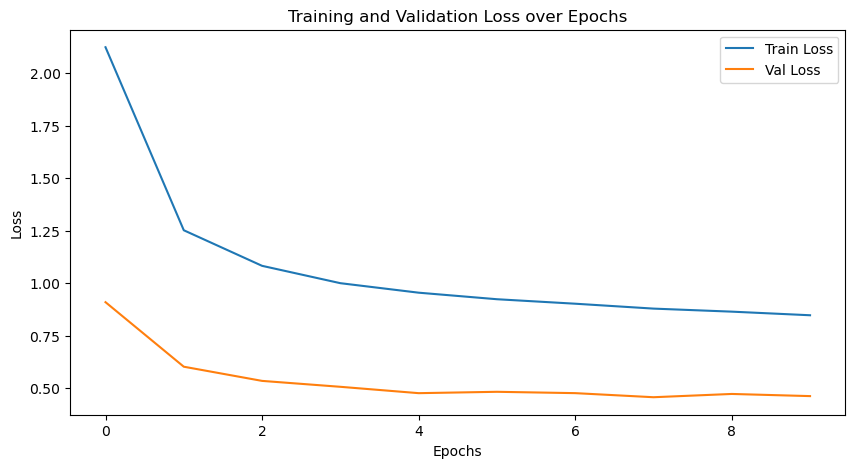

In [ ]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
def compute_class_iou(pred, target, num_classes):
    ious = np.zeros(num_classes)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union != 0:
            ious[cls] = intersection / union
    return ious

def evaluate_model(model, test_loader, classes):
    model.eval()
    class_ious = {cls: 0 for cls in classes}
    merged_classes = []
    merged_ious = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.cuda(), labels.cuda()
            with autocast():
                outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for pred, label in zip(preds, labels):
                pred = pred.cpu().numpy().flatten()
                label = label.cpu().numpy().flatten()

                for class_idx in np.unique(label):
                    if class_idx in np.unique(pred):
                        iou = compute_class_iou(pred, label, len(classes))[class_idx]
                        class_ious[classes[class_idx]] += iou

    for class_name in classes:
        if class_name == "pole":
            other_object_idx = classes.index("other-object")
            class_ious[classes[other_object_idx]] += class_ious[class_name]
        elif class_name == "asphalt/concrete":
            other_terrain_idx = classes.index("other-terrain")
            class_ious[classes[other_terrain_idx]] += class_ious[class_name]
        elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[class_name])

    merged_class_ious = dict(zip(merged_classes, merged_ious))
    return merged_class_ious

# Evaluate the model
classes = METAINFO['classes']
merged_class_ious = evaluate_model(trained_model, test_loader, classes)

In [ ]:
# Print IoU results
print("\nClass-wise IoU:")
total_iou = 0
for class_name, iou in sorted(merged_class_ious.items()):
    total_iou += iou / len(test_loader.dataset) * 100
    print(f"Class {class_name:<20} IoU: {iou / len(test_loader.dataset) * 100:.4f}")

# Calculate Mean IoU
mean_iou = total_iou / 15
print(f"\nMean IoU: {mean_iou:.4f}")
# Save the trained model
torch.save(trained_model.state_dict(), 'adamw_model_unet.pth')
print("Model saved as 'adamw_model_unet.pth'")


Class-wise IoU:
Class bush/shrub           IoU: 0.0220
Class dirt                 IoU: 56.1723
Class fence                IoU: 0.0000
Class grass                IoU: 48.8070
Class gravel               IoU: 0.2119
Class log                  IoU: 0.0000
Class mud                  IoU: 0.0000
Class other-object         IoU: 0.0000
Class other-structure      IoU: 0.0286
Class other-terrain        IoU: 0.0000
Class rock                 IoU: 0.0000
Class sky                  IoU: 51.7457
Class tree-foliage         IoU: 83.4934
Class tree-trunk           IoU: 44.9596
Class water                IoU: 0.0000

Mean IoU: 19.0294
Model saved as 'final_model.pth'


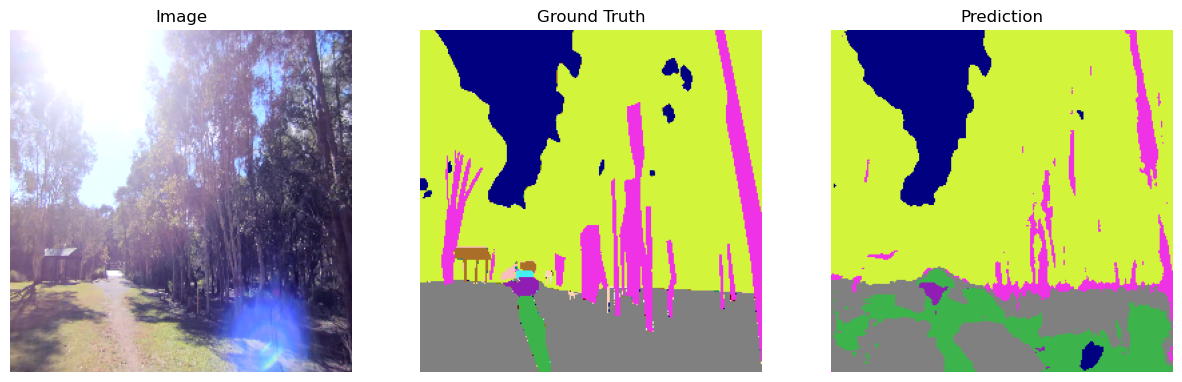

In [ ]:
# Convert label to RGB for visualization
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

# Visualize a sample
def visualize_sample(model, data_loader, palette):
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            sample_image = images[0].cpu().permute(1, 2, 0).numpy()
            sample_mask = labels[0].cpu().numpy()
            sample_pred = preds[0].cpu().numpy()
            break  # Visualize the first batch only

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(sample_image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(label_to_rgb(sample_mask, palette))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(label_to_rgb(sample_pred, palette))
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

# Visualize a sample
visualize_sample(trained_model, test_loader, METAINFO['palette'])